Name: Surbhi Khatri
<br>
Github Username: surbhikhatri
<br>
USC ID: 9893833133
<br>

In [1]:
from pathlib import Path
import logging
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.models import Sequential
import numpy as np
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
import random
import os
from keras import Model
from keras.layers import Dropout, Dense, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from sklearn.metrics import confusion_matrix


2023-12-10 20:53:21.927429: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 20:53:21.948074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 20:53:21.948095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 20:53:21.948593: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 20:53:21.951975: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

*** 1 (c) Data Augmentation and Prep ***

In [4]:
def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):
        img_loc_str = img_loc.numpy().decode('utf-8')
        img = Image.open(img_loc_str).convert('RGB')
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])
        img = img / 255.0
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        return img, label

    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    X.set_shape([299, 299, 3])
    y.set_shape([])
    return X, y

def load_and_preprocess_training(img_loc, label):
    #### Data Augmentation ####
    def _inner_function(img_loc, label):
        img_loc_str = img_loc.numpy().decode('utf-8')
        img = Image.open(img_loc_str).convert('RGB')
        img = np.array(img)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        img = tf.image.adjust_brightness(img, 0.2)
        img = tf.image.random_saturation(img, lower=0.1, upper=0.2)
        img = tf.image.resize(img, [299, 299])
        img = img / 255.0
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        return img, label

    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    X.set_shape([299, 299, 3])
    y.set_shape([])
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))


random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess_training, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

2023-12-10 20:53:45.331564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 20:53:45.392254: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 20:53:45.392287: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 20:53:45.394853: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 20:53:45.394883: I external/local_xla/xla/stream_executor

In [5]:
comparison_table = pd.DataFrame(columns=['Model','Test Accuracy','Precision','Recall','F1'])


*** 1 (c) ii ***
Training CNN + MLP

In [6]:
# Define the 3 layer Convolution network for binary image classification

# usinf Keras
model = keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    # input layer which 64 kernels and filter size 3 * 3 and activation function Relu
    layers.BatchNormalization(),
    # perform batch normalization as mentioned in the question
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # first layer which 128 kernels and filter size 3 * 3 and activation function Relu
    # also using L2 regularization
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),

    # flatten the last layer
    layers.Flatten(),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # output layer has softmax layer with output of 2 neurons to classify frost or background
    layers.Dense(2, activation='softmax')
])

In [7]:
# using Adam optimazer and cross entropy for loss functions
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# define early stopping as mentioned, I'm using patience of 5 epochs and keep the network parameters that have the lowest validation errors
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# run for 20 epochs
history = model.fit(tf_dataset_train, epochs=30, validation_data=tf_dataset_val, callbacks=[early_stopping])

Epoch 1/30


/home/saket/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/saket/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
2023-12-10 20:54:18.848187: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-10 20:54:18.983650: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-12-10 20:54:19.473231: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-12-10 20:54:19.983023: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6544dee050 initialized for platform CUDA (this does not guarantee t

928/928 [==============================] - 260s 275ms/step - loss: 3.3511 - accuracy: 0.8181 - val_loss: 2.0929 - val_accuracy: 0.7818
Epoch 2/30
928/928 [==============================] - 252s 271ms/step - loss: 1.4913 - accuracy: 0.8932 - val_loss: 1.8619 - val_accuracy: 0.6835
Epoch 3/30
928/928 [==============================] - 251s 270ms/step - loss: 1.1132 - accuracy: 0.9204 - val_loss: 3.5851 - val_accuracy: 0.3250
Epoch 4/30
928/928 [==============================] - 250s 269ms/step - loss: 0.9360 - accuracy: 0.9298 - val_loss: 7.9905 - val_accuracy: 0.3368
Epoch 5/30
928/928 [==============================] - 253s 272ms/step - loss: 0.7847 - accuracy: 0.9435 - val_loss: 1.5688 - val_accuracy: 0.6468
Epoch 6/30
928/928 [==============================] - 251s 270ms/step - loss: 0.7241 - accuracy: 0.9435 - val_loss: 0.8003 - val_accuracy: 0.8979
Epoch 7/30
928/928 [==============================] - 250s 269ms/step - loss: 0.6467 - accuracy: 0.9502 - val_loss: 1.1556 - val_accura

In [8]:
count = 0
def evaluate_accuracy(model, dataset, title, add_to_comparison):
    predicted_labels = []
    true_labels = []
    for images, labels in dataset:
        predictions = model.predict(images, verbose = 0)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(np.argmax(predictions, axis=1))
    print("")
    print(title)
    print("Classification report")
    print(classification_report(true_labels, predicted_labels))
    print("Confusion Matrix")
    print(confusion_matrix(true_labels, predicted_labels))
    if add_to_comparison:
        precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
        accuracy = accuracy_score(true_labels, predicted_labels)
        comparison_table.loc[count] = [title, accuracy, precision_test, recall_test, f1_test]
    print("")
    

def plot_figures(model_history):
    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']
    err = [1 - x for x in accuracy]
    val_err = [1 - x for x in val_accuracy]
    epochs = range(len(accuracy))
    
    plt.plot(epochs, err)
    plt.plot(epochs, val_err)
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend(['train_error', 'validation_error'])
    plt.title('Training + Validation Error vs Epochs')
    plt.show()


*** 1 (c) ii.Report Precision, Recall, and F1 score for your model. ***


CNN + MLP Train Data
Classification report
              precision    recall  f1-score   support

           0       0.49      1.00      0.66     12235
           1       1.00      0.27      0.42     17444

    accuracy                           0.57     29679
   macro avg       0.74      0.63      0.54     29679
weighted avg       0.79      0.57      0.52     29679

Confusion Matrix
[[12234     1]
 [12742  4702]]


CNN + MLP Test Data
Classification report
              precision    recall  f1-score   support

           0       0.72      0.99      0.83      4418
           1       1.00      0.79      0.88      8405

    accuracy                           0.86     12823
   macro avg       0.86      0.89      0.86     12823
weighted avg       0.90      0.86      0.86     12823

Confusion Matrix
[[4387   31]
 [1748 6657]]


CNN + MLP Val Data
Classification report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7654
           1  

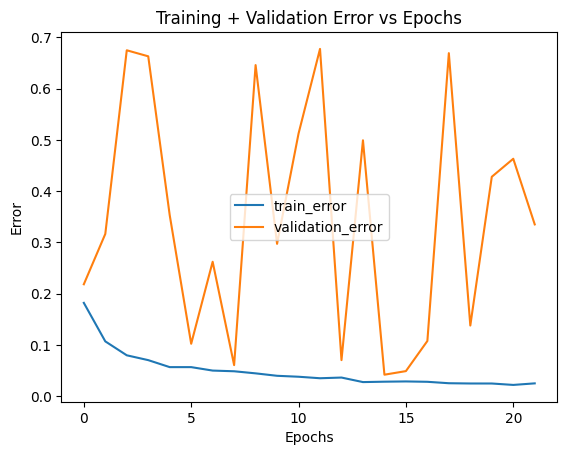

In [9]:
evaluate_accuracy(model, tf_dataset_train, "CNN + MLP Train Data", False)
evaluate_accuracy(model, tf_dataset_test, "CNN + MLP Test Data", True)
evaluate_accuracy(model, tf_dataset_val, "CNN + MLP Val Data", False)
plot_figures(history)
count += 1